<a href="https://colab.research.google.com/github/ArnovanHilten/GenNet/blob/dev/Proof_of_Concept_GenNet_Non_Linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proof of Concept GenNet


1. Copy to playground
2. Press Runtime > Run all or ctrl + F9

## Initialization

In [1]:
pip install numpy==1.19.3

In [2]:
pip install tensorflow==2.4.0

In [3]:
#@title Importing python modules { display-mode: "form" }

import tensorflow as tf
import os
from scipy.sparse import coo_matrix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as K
import sklearn.metrics as skm
import scipy
import sys

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as Kb
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import InputSpec
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.util.tf_export import tf_export


In [4]:
#@title Locally-Directed1D layer
"""Locally-Directed1D layer.
"""



@tf_export('keras.layers.LocallyDirected1D')
class LocallyDirected1D(Layer):
    """Locally-Directed1D layer for 1D inputs.

  The `LocallyDirected1D` layer works similarly to
  the `Conv1D` layer, except that weights are unshared,
  that is, a different set of filters is applied at each different patch
  of the input.

  Example:
  ```python
      # apply a unshared weight convolution 1d of length 3 to a sequence with
      # 10 timesteps, with 64 output filters
      model = Sequential()
      model.add(LocallyDirected1D(64, 3, input_shape=(10, 32)))
      # now model.output_shape == (None, 8, 64)
      # add a new conv1d on top
      model.add(LocallyDirected1D(32, 3))
      # now model.output_shape == (None, 6, 32)
  ```

  Arguments:
      mask: sparse matrix with shape (input, output) connectivity matrix,
            True defines connection between (in_i, out_j), should be sparse (False,0) >> True
            should be scipy sparese matrix in COO Format!
      filters: Integer, the dimensionality of the output space
          (i.e. the number of output filters in the convolution).
      kernel_size: An integer or tuple/list of a single integer,
          specifying the length of the 1D convolution window.
      strides: An integer or tuple/list of a single integer,
          specifying the stride length of the convolution.
          Specifying any stride value != 1 is incompatible with specifying
          any `dilation_rate` value != 1.
      padding: Currently only supports `"valid"` (case-insensitive).
          `"same"` may be supported in the future.
      data_format: A string,
          one of `channels_last` (default) or `channels_first`.
          The ordering of the dimensions in the inputs.
          `channels_last` corresponds to inputs with shape
          `(batch, length, channels)` while `channels_first`
          corresponds to inputs with shape
          `(batch, channels, length)`.
          It defaults to the `image_data_format` value found in your
          Keras config file at `~/.keras/keras.json`.
          If you never set it, then it will be "channels_last".
      activation: Activation function to use.
          If you don't specify anything, no activation is applied
          (ie. "linear" activation: `a(x) = x`).
      use_bias: Boolean, whether the layer uses a bias vector.
      kernel_initializer: Initializer for the `kernel` weights matrix.
      bias_initializer: Initializer for the bias vector.
      kernel_regularizer: Regularizer function applied to
          the `kernel` weights matrix.
      bias_regularizer: Regularizer function applied to the bias vector.
      activity_regularizer: Regularizer function applied to
          the output of the layer (its "activation")..
      kernel_constraint: Constraint function applied to the kernel matrix.
      bias_constraint: Constraint function applied to the bias vector.

  Input shape:
      3D tensor with shape: `(batch_size, steps, input_dim)`

  Output shape:
      3D tensor with shape: `(batch_size, new_steps, filters)`
      `steps` value might have changed due to padding or strides.
  """

    def __init__(self,
                 mask,
                 filters,
                 padding='valid',
                 data_format=None,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(LocallyDirected1D, self).__init__(**kwargs)
        self.filters = filters
        self.padding = conv_utils.normalize_padding(padding)
        self.data_format = conv_utils.normalize_data_format(data_format)
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(ndim=3)
        self.mask = mask

    @tf_utils.shape_type_conversion
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            input_dim, input_length = input_shape[1], input_shape[2]
        else:
            input_dim, input_length = input_shape[2], input_shape[1]

        if input_dim is None:
            raise ValueError('Axis 2 of input should be fully-defined. '
                             'Found shape:', input_shape)
        self.output_length = self.mask.shape[1]
        if self.data_format == 'channels_first':
            self.kernel_shape = (input_dim, input_length,
                                 self.filters, self.output_length)
        else:
            self.kernel_shape = (input_length, input_dim,
                                 self.output_length, self.filters)


        self.kernel = self.add_weight(shape=(len(self.mask.data),),    #sum of all nonzero values in mask sum(sum(mask))
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.kernel_idx = sorted(get_idx(self.mask))


        if self.use_bias:
            self.bias = self.add_weight(
                shape=(self.output_length, self.filters),
                initializer=self.bias_initializer,
                name='bias',
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint)
        else:
            self.bias = None

        if self.data_format == 'channels_first':
            self.input_spec = InputSpec(ndim=3, axes={1: input_dim})
        else:
            self.input_spec = InputSpec(ndim=3, axes={-1: input_dim})
        self.built = True


    def call(self, inputs):

        # output = local_conv_matmul(inputs, self.kernel_mask,
        #                            self.output_length)

        output = local_conv_matmul_sparse(inputs, self.mask, self.kernel, self.kernel_idx, self.output_length, self.filters)



        if self.use_bias:
            output = Kb.bias_add(output, self.bias, data_format=self.data_format)

        output = self.activation(output)
        return output

    # def get_config(self):  # delete this?
    #     config = {
    #         'filters':
    #             self.filters,
    #         'padding':
    #             self.padding,
    #         'data_format':
    #             self.data_format,
    #         'activation':
    #             activations.serialize(self.activation),
    #         'use_bias':
    #             self.use_bias,
    #         'kernel_initializer':
    #             initializers.serialize(self.kernel_initializer),
    #         'bias_initializer':
    #             initializers.serialize(self.bias_initializer),
    #         'kernel_regularizer':
    #             regularizers.serialize(self.kernel_regularizer),
    #         'bias_regularizer':
    #             regularizers.serialize(self.bias_regularizer),
    #         'activity_regularizer':
    #             regularizers.serialize(self.activity_regularizer),
    #         'kernel_constraint':
    #             constraints.serialize(self.kernel_constraint),
    #         'bias_constraint':
    #             constraints.serialize(self.bias_constraint),
    #     }
    #     base_config = super(LocallyDirected1D, self).get_config()
    #     return dict(list(base_config.items()) + list(config.items()))


def local_conv_matmul_sparse(inputs, mask, kernel, kernel_idx, output_length, filters):
    """Apply N-D convolution with un-shared weights using a single matmul call.

  Arguments:
      inputs: (N+2)-D tensor with shape
          `(batch_size, channels_in, d_in1, ..., d_inN)`
          or
          `(batch_size, d_in1, ..., d_inN, channels_in)`.
      mask: sparse matrix COO format connectivity matrix, shape: (input layer, output layer)
      kernel_idx =  the transposed mask matrix indices
      kernel: the unshared weights for N-D convolution,
          an (N+2)-D tensor of shape:
          `(d_in1, ..., d_inN, channels_in, d_out2, ..., d_outN, channels_out)`
          or
          `(channels_in, d_in1, ..., d_inN, channels_out, d_out2, ..., d_outN)`,
          with the ordering of channels and spatial dimensions matching
          that of the input.
          Each entry is the weight between a particular input and
          output location, similarly to a fully-connected weight matrix.
      output_shape: (mask.shape[1], mask.shape[0]) is used instead.
      output_length = length of the output
      filters =  standard 1

  Returns:
      Output (N+2)-D tensor with shape `output_shape`.
  """
    output_shape = (mask.shape[1], mask.shape[0])
    inputs_flat = Kb.reshape(inputs, (Kb.shape(inputs)[0], -1)) 

    print("kernel_idx", len(kernel_idx))
    print("inputs", Kb.shape(inputs_flat))
    print("kernel", Kb.shape(kernel))

    output_flat = Kb.sparse_ops.sparse_tensor_dense_mat_mul(
        kernel_idx, kernel, (mask.shape[1], mask.shape[0]), inputs_flat, adjoint_b=True)
    # tf.print(kernel)
    
    output_flat_transpose= Kb.transpose(output_flat)
    output_reshaped = Kb.reshape(output_flat_transpose, [-1, output_length, filters])
    # output_reshaped = Kb.reshape(output_flat_transpose,[Kb.shape(output_flat_transpose)[0],] + output_shape.as_list()[1:])
    return output_reshaped

def get_idx(mask):
  """"returns the transposed coordinates in tuple form:
   [(mask.col[0], mask,row[0])...[mask.col[n], mask.row[n])]"""
  coor_list = []
  for i, j in zip(mask.col, mask.row):
    coor_list.append((i,j))

  return coor_list








In [5]:
#@title Utility functions { display-mode: "form" }
#

tf.keras.backend.set_epsilon(0.00001)
global weight_negative_class
global weight_possitive_class
global data_path

def weighted_binary_crossentropy(y_true, y_pred):
    y_true = K.backend.clip(y_true, 0.0001, 1)
    y_pred = K.backend.clip(y_pred, 0.0001, 1)

    return K.backend.mean(
        -y_true * K.backend.log(y_pred + 0.0001) * weight_possitive_class - (1 - y_true) * K.backend.log(
            1 - y_pred + 0.0001) * weight_negative_class)



def progressBar(value, end_value, bar_length=50):
    percent = float(value + 1) / end_value
    arrow = '-' * int(round(percent * bar_length) - 1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))

    if value >= end_value:
        sys.stdout.write("\n")

    sys.stdout.flush()


def sensitivity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.keras.backend.clip(y_pred, 0, 1)
    y_true = tf.keras.backend.clip(y_true, 0, 1)

    y_pred = tf.keras.backend.round(y_pred)

    true_p = K.backend.sum(K.backend.round(y_pred) * y_true)
    pos = tf.keras.backend.sum(y_true)
    sensitivity1 = tf.keras.backend.clip((true_p / (pos + 0.00001)), 0, 1)
    return sensitivity1

def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.keras.backend.clip(y_pred, 0, 1)
    y_true = tf.keras.backend.clip(y_true, 0, 1)

    neg_y_true = 1 - y_true
    neg_y_pred = 1 - K.backend.round(y_pred)
    fp = K.backend.sum(neg_y_true * K.backend.round(y_pred))
    tn = K.backend.sum(neg_y_true * neg_y_pred)
    specificity1 = tn / (tn + fp + 0.00001)
    return tf.keras.backend.clip(specificity1, 0, 1)


def evaluate_performance(y,p):
    print("\n")
    print("Confusion matrix")
    confusion_matrix = skm.confusion_matrix(y, p.round())
    print(confusion_matrix)

    fpr, tpr, thresholds = skm.roc_curve(y, p)
    roc_auc = skm.auc(fpr, tpr)
    print("\n")
    print("Area under the Curve (AUC) = ", roc_auc)

    specificity = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])
    print('Specificity = ', specificity)

    sensitivity = confusion_matrix[1, 1] / (confusion_matrix[1, 0] + confusion_matrix[1, 1])
    print('Sensitivity = ', sensitivity)
    print("F_1 score = " + str(skm.f1_score(y, p.round())))
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
            lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.plot(1 - specificity, sensitivity, color='b', marker='o')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()



## Parameters



In [6]:
# Hyperparameters of the simulation and the network training.

jobid = 1
modeltype = "GenNet_proof_of_concept_network"
weight_possitive_class = 1 
weight_negative_class = 1
batch_size = 32
startindex = 0
stopindex = -1
inputsize = 100
max_id = 10
train_size = 10000
val_size = 2000
test_size = 2000
epochs = 25
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

## Create data, mask and network

In [7]:
#@title Functions for creating the network, simulations and mask

def GenNet_proof_of_concept_network(inputsize, mask):
    ''' The function that creates the neural network. 
    The locallyDirected1D layer let's you define all the connections yourself 
    with the help of a mask, the rest is standard Keras
    The created network is plotted at the end of the notebook'''

    inputs_ = K.Input((inputsize,), name='inputs_')

    Input_layer = K.layers.Reshape(input_shape=(inputsize,), target_shape=(inputsize, 1))(inputs_)
    
    # next line we use the new Gennet layer (LocallyDirected1D) to define all the connections ourself
    Gene_layer = LocallyDirected1D(mask=mask, filters=1, input_shape=(inputsize, 1), name="gene_layer",)(Input_layer)
    Gene_layer = K.layers.Flatten()(Gene_layer)
    Gene_layer = K.layers.Activation("tanh")(Gene_layer) #gene layer

    BatchNorm = K.layers.BatchNormalization(center=False, scale=False, name="inter_out")(Gene_layer)
    
    Prediction_layer = K.layers.Dense(units=1,    kernel_regularizer=K.regularizers.l1(0.01) )(BatchNorm)
    Prediction_layer = K.layers.Activation("sigmoid")(Prediction_layer)
    model = K.Model(inputs=inputs_, outputs=Prediction_layer)
    return model

def make_mask_gene_layer(inputsize):
    '''We create a simple mask for this network, the first 5 are connected to the 
    first neuron. SNPs 5 to 10 are connected to the second neuron etc. 
    We save it as a sparse matrix.
    The created network is plotted at the end of the notebook'''
    mask_d  = np.zeros((inputsize,10), np.bool)
    mask_d[0:5,0]= True
    mask_d[5:10,1]= True
    mask_d[10:20,2]=True
    mask_d[20:30,3]=True
    mask_d[30:50,4]=True
    mask_d[50:70,5]= True
    mask_d[70:80,6]= True
    mask_d[80:90,7]=True
    mask_d[90:95,8]=True
    mask_d[95:100,9]=True
    mask =  coo_matrix(mask_d)
    gene_end =[0,5,10,20,30,50,70,80,90,95,100]  
    return mask, gene_end


def get_simdata(num_patients=100, num_features=100,
                    ind_linked=[   [[0, 0], [4, 2]],   [[6, 2], [9, 0]], 
                                   [[12, 2], [19, 2]],   [[21, 2], [29, 0]], [[35, 0], [45, 2]] ] # causal SNPs
                    , n=2, p=0.3,
                    random_seed=42):
    '''A function to create some simulated non-linear data.  
    [[0, 0], [4, 2]] means that whenever the first value/SNP is 0 and the 4th has 
    value 2 then there is an effect'''
    
    np.random.seed(random_seed)
    basis = np.zeros([num_patients, num_features])
    effectsize = 1

    for k in range(num_features):
        basis[:, k] = np.random.binomial(n, p, num_patients)

    status = np.zeros(num_patients)
    for patient in range(num_patients):
        for linked in ind_linked:
            temp = np.zeros([len(linked)])
            i = 0
            for element in linked:
                if basis[patient, element[0]] == element[1]:
                    temp[i] = 1
                i += 1
            if np.min(temp) > 0:
                status[patient] = 1



    num_diseased = np.sum(status)
    causal_snps = [[x[0][0] for x in ind_linked],[x[1][0] for x in ind_linked]]
    print(("Created dataset[", num_patients, " x ", num_features, "] with", num_diseased, "diseased"))
    return basis, status,causal_snps




## Train and evaluate network


kernel_idx 100
inputs Tensor("gene_layer/Shape_1:0", shape=(2,), dtype=int32)
kernel Tensor("gene_layer/Shape_2:0", shape=(1,), dtype=int32)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs_ (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 100, 1)            0         
_________________________________________________________________
gene_layer (LocallyDirected1 (None, 10, 1)             110       
_________________________________________________________________
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
inter_out (BatchNormalizatio (None, 10)             

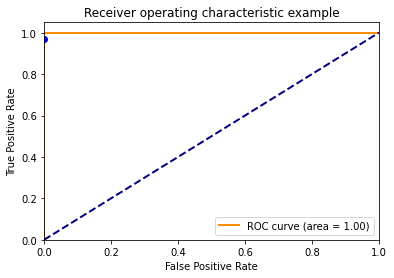

In [8]:
# all functions used here can be found under create data. You can easily change the causal SNPs there and run the notebook to see the effect of such a change.

genemask, gene_end = make_mask_gene_layer(inputsize)  # get the mask to know which SNP connect to which gene

model = GenNet_proof_of_concept_network(inputsize=int(inputsize), mask=genemask)  # create the neural network

model.compile(loss=weighted_binary_crossentropy, optimizer=optimizer, metrics=["accuracy", sensitivity, specificity]) # compile the network
print(model.summary())

xtrain, ytrain, causal_snps =get_simdata(num_features=inputsize,num_patients=train_size, random_seed=1+ jobid) # get the training data, we use a different seed than for the validation and test to get unique data
xval, yval, _ =get_simdata(num_features=inputsize,num_patients=val_size, random_seed=21 + jobid) # get validation data, note that it has a different random seed

earlystop = K.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='auto', restore_best_weights=True) # we stop training after not improving after 50 epochs on the validation data
model.fit(x=xtrain, y=ytrain, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[earlystop], validation_data=(xval,yval), shuffle=True) # train the neural network


pval = model.predict(xval) # Get the validation predictions

evaluate_performance(yval, pval) # evaluate the validation predictions



evaluate over test patients
('Created dataset[', 2000, ' x ', 100, '] with', 344.0, 'diseased')


Confusion matrix
[[1656    0]
 [  13  331]]


Area under the Curve (AUC) =  0.9998525446579036
Specificity =  1.0
Sensitivity =  0.9622093023255814
F_1 score = 0.9807407407407407


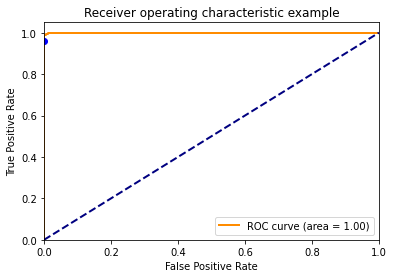

In [9]:
print("evaluate over test patients")
xtest, ytest, _ = get_simdata(num_features=inputsize, num_patients=test_size, random_seed=12+ jobid) # get the test set
ptest = model.predict(xtest) # predict with the trained neural network, optimized with the validation set
evaluate_performance(ytest, ptest) # get the unbiased predictions

## Compare with logistic regression 



Confusion matrix
[[1582   74]
 [ 220  124]]


Area under the Curve (AUC) =  0.6578895629704528
Specificity =  0.9553140096618358
Sensitivity =  0.36046511627906974
F_1 score = 0.4575645756457565


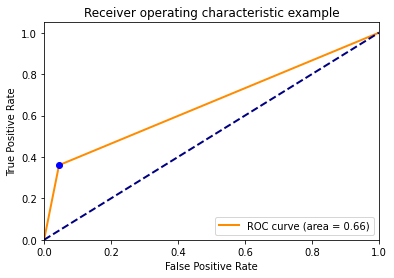

In [10]:
import sklearn
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs').fit(xtrain, ytrain)
ptest_lr = clf.predict(xtest)

evaluate_performance(ytest, ptest_lr)

### Inspect the betas of the logistic regression to see which SNPs are important for prediction

In [14]:
#@title Show the important weights for logistic regression

betas_lr = pd.DataFrame(clf.coef_[:].T, columns=["Betas logistic regression"])
betas_lr_s = betas_lr.sort_values("Betas logistic regression",ascending=False)
print("Causal SNPs are:", causal_snps)
betas_lr_s.head(12)




Causal SNPs are: [[ 0  6 12 21 35]
 [ 4  9 19 29 45]]


,Betas logistic regression
45,1.215506
21,1.110963
6,1.103864
4,1.082567
12,0.293083
19,0.284680
33,0.099352
80,0.096045
76,0.094810
48,0.093763


On this toy example the network performs thus substantially better than logistic regression. We will inspect interpretability next by plotting the weights


## Plot network

We plot the network below. The line-thickness between the nodes represent the strenght of the connections (magnitude of the weight)

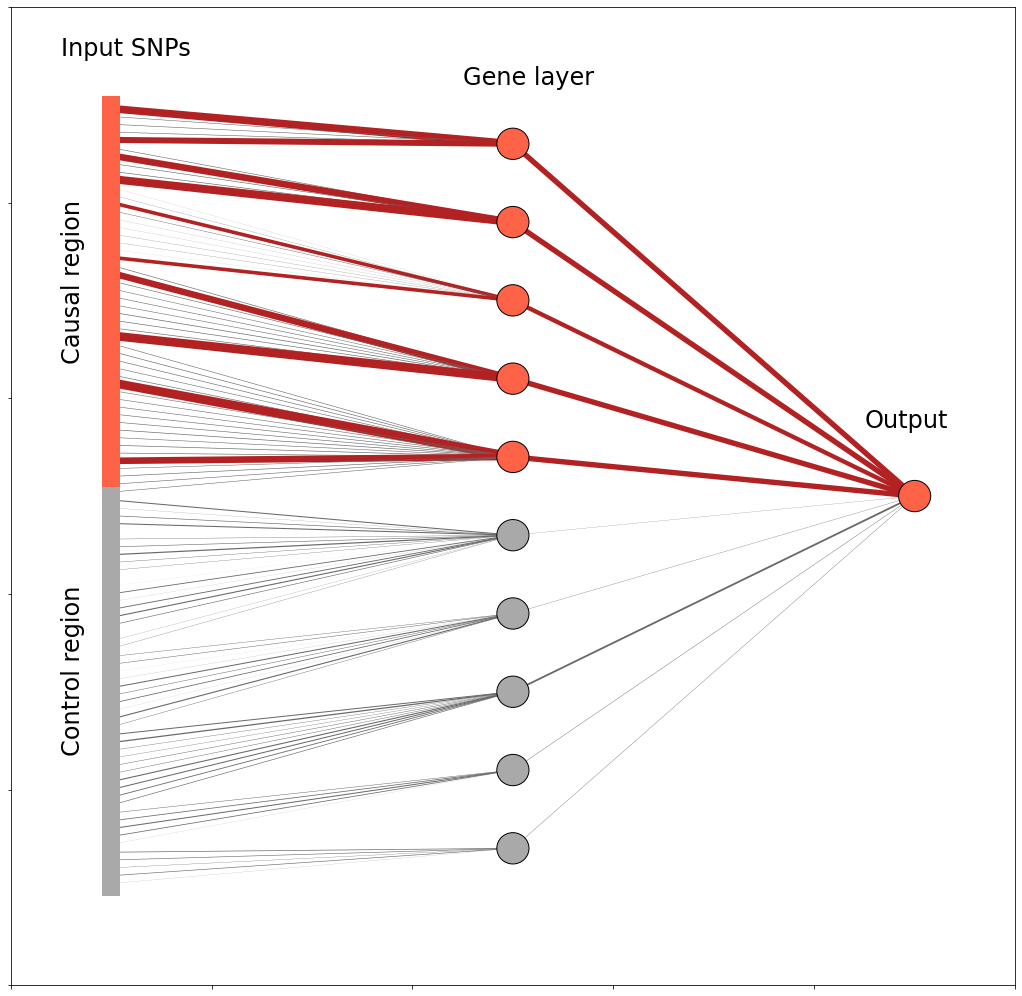

In [12]:
#@title Plot network 
from matplotlib import cm
import matplotlib.patches as mpatches

weight_locally = model.layers[2].get_weights()[0]
weights_dense = model.layers[5].get_weights()[0]

causal_snps = np.array(causal_snps)
colors = plt.cm.tab10(np.linspace(0,1,10))
fig = plt.figure(figsize=(18, 18))

n_layers = 3
gene_mask = genemask.todense()
layer_sizes = [genemask.shape[0], genemask.shape[1], 1]


ax = fig.gca()
top=0.9
bottom=0.1
left = 0.1
right = 0.9
                 
v_spacing = (top - bottom)/float(max(layer_sizes))
h_spacing = (right - left)/float(len(layer_sizes) - 1)


causal_red = "firebrick" #"#7dcfe2"
causal_circle_red = "tomato" #"#4b78b5"
gray1 = "darkgrey"
gray2 = "dimgray"

linewith_genes = (weights_dense * 5 + 0.5)
linewith_snps = (weight_locally* 5+0.5)
colormap_snps = np.zeros(inputsize, dtype=object)
colormap_snps[:] =gray2
colormap_snps[causal_snps] = causal_red
colormap_genes = np.zeros((gene_mask.shape[1]), dtype=object)
colormap_genes[:int(len(colormap_genes)/2)] = causal_red
colormap_genes[int(len(colormap_genes)/2):] = gray2
colormap_circle_genes = np.zeros((gene_mask.shape[1]), dtype=object)
colormap_circle_genes[:int(len(colormap_circle_genes)/2)] = causal_circle_red
colormap_circle_genes[int(len(colormap_circle_genes)/2):] = gray1



#SNPs
n=0    
layer_size = layer_sizes[0]
layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2

y_snps=[]
layer_size_a = gene_mask.shape[0]
layer_size_b = gene_mask.shape[1]
layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
for m in range(layer_size):
    y_snps.append(layer_top_a - m*v_spacing) 
        
line_vert_1 =plt.Line2D(xdata=[n*h_spacing + left, n*h_spacing + left],
                                  ydata=[top, ((top-bottom)/2)+bottom ],
                                  c=causal_circle_red, linewidth = "18")


line_vert_2 =plt.Line2D(xdata=[n*h_spacing + left, n*h_spacing + left],
                                  ydata=[((top-bottom)/2)+bottom, bottom],
                                  c=gray1 , linewidth = "18")



## Gene layer
layer_sizes2 = [genemask.shape[1], 1]
v_spacing = (top - bottom)/float(max(layer_sizes2))


n=1
layer_size = layer_sizes[1]
layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2

layer2xy = []
for m in range(layer_size):
    layer2xy.append( (n*h_spacing + left, layer_top - m*v_spacing))
    circle = plt.Circle(xy=layer2xy[m], radius=v_spacing/5,
                        color=colormap_circle_genes[m], ec='k', zorder=4)
    ax.add_artist(circle)

    
## Dense layer

n=2
layer_size = layer_sizes[2]
layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2


for m in range(layer_size):
    circle = plt.Circle(xy=(n*h_spacing + left, layer_top - m*v_spacing), radius=v_spacing/5,
                         color = causal_circle_red, ec='k', zorder=4)
    ax.add_artist(circle)   



# draw lines    
teller_snp_lines = 0
for column in range(gene_mask.shape[1]):
    rows = np.where(gene_mask[:,column]!=0)
    for row in rows[0]:
            line = plt.Line2D(xdata=[left,        layer2xy[column][0]],
                              ydata=[y_snps[row], layer2xy[column][1]],
                              c = colormap_snps[teller_snp_lines], linewidth = linewith_snps[teller_snp_lines])
            ax.add_artist(line)
            teller_snp_lines +=1
            
for column in range(gene_mask.shape[1]):
        line = plt.Line2D(xdata=[layer2xy[column][0],right],
                          ydata=[layer2xy[column][1], layer_top - m*v_spacing],
                          c = colormap_genes[column], linewidth = linewith_genes[column])
        ax.add_artist(line)



plt.annotate("Control region" ,xy=(left/2,0.24), size = 24, rotation = "90")
plt.annotate("Causal region", xy=(left/2,0.64), size=24, rotation = "90")
plt.annotate("Input SNPs", xy=(left-0.05,0.95), size=24, rotation = "0")
plt.annotate("Gene layer", xy=(layer2xy[0][0]-0.05,0.92), size=24)
plt.annotate("Output", xy=(right-0.05,0.57), size=24)
        
ax.add_artist(line_vert_1)
ax.add_artist(line_vert_2)
ax.set_yticklabels([])
ax.set_xticklabels([])

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False

plt.savefig("simulation_non_linear4.pdf")
plt.show()


The network assigns high weights to causal SNP pairs ([0, 4], [6, 9],[12, 19], [21, 29],[35, 45]) The network is thus fully interpretable because each node and connection represents a contribution of the SNP to the gene or the contribution of the gene on the output. The weights gives an indication on how strong this contribition is.

The network is interpretable because it is not fully connected, instead prior knowledge is used to create an interpretable neural network.
